In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import cv2

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import argparse
from tensorflow.keras.callbacks import ModelCheckpoint
from livelossplot.tf_keras import PlotLossesCallback
%matplotlib inline

In [3]:
face_dataset_folders=(glob.glob("C:/Users/Fakeha Rahman/Downloads/RMFD/self-built-masked-face-recognition-dataset/AFDB_face_dataset/*"))
# print(face_dataset_folders)
mask_dataset_folders=(glob.glob("C:/Users/Fakeha Rahman/Downloads/RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/*"))

In [4]:
# tot=0
# for i in face_dataset_folders:
#     folder=glob.glob(i+"/*")
# #     print(len(folder))
#     tot+=(len(folder))
#     while(len(folder)>6):
#         os.remove(folder[0].replace("\\", "/"))
#         del folder[0]
# print(tot)

2760


In [5]:
# def load_images_from_folder(folder):
#     images = []
#     for filename in os.listdir(folder):
#         if any([filename.endswith(x) for x in ['.jpeg', '.jpg']]):
#             img = cv2.imread(os.path.join(folder, filename))
#             if img is not None:
#                 images.append(img)
#     return images

In [6]:
# def img_to_array(path):
#     imgs=[]
#     for i in path:
#         folder=glob.glob(i+"/*")
#         imgs.extend(load_images_from_folder(i))
#     return imgs

In [7]:
# face_imgs=img_to_array(face_dataset_folders)
# mask_imgs=img_to_array(mask_dataset_folder)

In [8]:
# print(len(face_imgs))
# print(len(mask_imgs))

In [9]:
def plot_img(img, title):
    imgplot = plt.imshow(img)
    plt.title(title)
    plt.show()

In [10]:
# plot_img(mask_imgs[130], "Masked Image Example")
# plot_img(face_imgs[145], "Unmasked Image Example")

In [11]:
# print(mask_imgs[7].shape)

In [12]:
labels=[]
data=[]
def create_data(folder, label):
    for i in folder:
        for filename in glob.glob(i+"/*"):
            image = load_img(filename, target_size=(224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)
            data.append(image)
            labels.append(label)


In [13]:
create_data(face_dataset_folders, 0)   
create_data(mask_dataset_folders, 1)

In [14]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


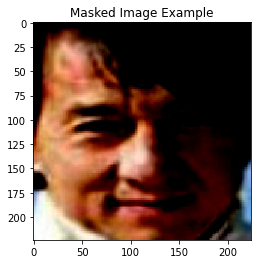

In [15]:
plot_img(data[140], "Masked Image Example")

In [16]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [17]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [18]:
aug = ImageDataGenerator(rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [19]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [20]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [21]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network


[INFO] compiling model...


In [22]:
print(labels.shape)
print(data.shape)

(4963, 2)
(4963, 224, 224, 3)


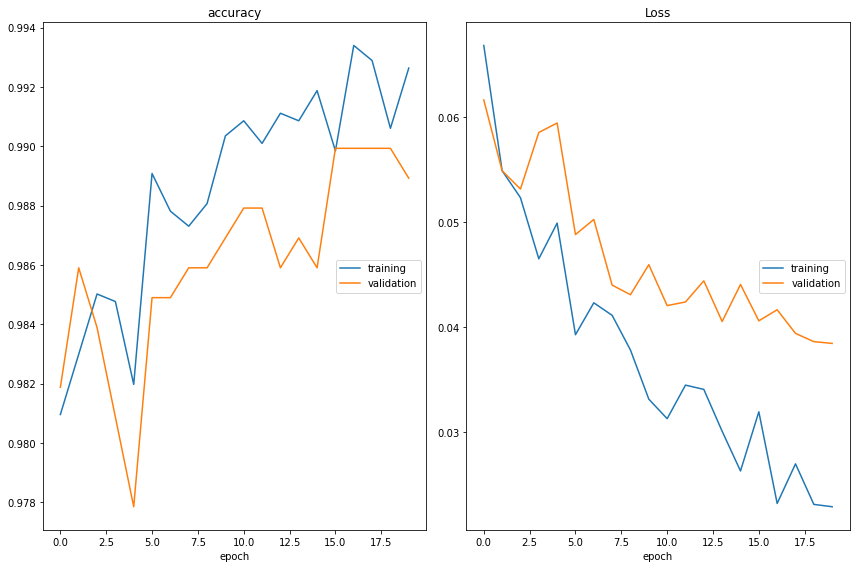

accuracy
	training         	 (min:    0.981, max:    0.993, cur:    0.993)
	validation       	 (min:    0.978, max:    0.990, cur:    0.989)
Loss
	training         	 (min:    0.023, max:    0.067, cur:    0.023)
	validation       	 (min:    0.038, max:    0.062, cur:    0.038)
Wall time: 37min 4s


In [24]:
%%time

# chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

callbacks = [PlotLossesCallback()]
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS, callbacks=callbacks)

In [26]:
model.save("Mask_detector_1.h5")

In [27]:
ev=model.evaluate(x=testX, y=testY)

32/32 [==============================] - 21s 642ms/step - loss: 0.0385 - accuracy: 0.9889
